# Analisis, Preprocesamiento y Experimentos de los Datos
## Librerías 

In [356]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import tsfel


# Definir un colormap para las curvas
colors = plt.get_cmap("mako")(np.linspace(0, 1, 3))

## Métodos Generales del Análisis

In [337]:
"""Método que consulta todos los valores unicos de los campos categóricos """
def check_categorical_unique(df_base):
    categorical_features=df_base.select_dtypes(include=['object']).columns
    print(categorical_features)
    for c in categorical_features:
        if c != 'Name':
            cases= df_base[c].unique().tolist()
            print(f'Columna: {c} Valores{cases}')

""" Método que muestra y guarda las gráficas relacionadas con las distribuiciones sobre el Kyu-Dan"""
def set_distributions_on_kd(df,name, movement):
    # Visualización de distribuciones
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    sns.boxplot(x="Kyu-Dan", y="Age", data=df, ax=axes[0, 0])
    axes[0, 0].set_title("Distribución de Edad por Kyu-Dan")

    sns.boxplot(x="Kyu-Dan", y="Experience", data=df, ax=axes[0, 1])
    axes[0, 1].set_title("Distribución de Experiencia por Kyu-Dan")

    sns.boxplot(x="Kyu-Dan", y="Weight", data=df, ax=axes[1, 0])
    axes[1, 0].set_title("Distribución de Peso por Kyu-Dan")

    sns.boxplot(x="Kyu-Dan", y="BMI", data=df, ax=axes[1, 1])
    axes[1, 1].set_title("Distribución de BMI por Kyu-Dan")

    plt.savefig(f"{name}.jpg", format="jpg", dpi=300)
    plt.tight_layout()
    plt.show()

"""Método que Muestra la Matriz de Correlación """
def set_corr_matrix(df, drop_cols, dataset_name):
    # Matriz de correlación
    plt.figure(figsize=(8, 6))
    corr_matrix = df.drop(columns=drop_cols).corr()
    sns.heatmap(corr_matrix, annot=True, cmap="mako", fmt=".2f")
    plt.title(f"Matriz de correlación {dataset_name}")
    plt.savefig(f"{dataset_name}_corr_matrix.jpg", format="jpg", dpi=300)
    plt.show()

## 1. Bokken Dataset 

In [324]:
df_bokken = pd.read_csv('bokken_data.csv')
df_bokken.head(3)

C:\Users\iiventura\AppData\Local\Temp\ipykernel_22028\3552201172.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bokken = pd.read_csv('bokken_data.csv')


,Time,ACCX_BOKKEN,ACCY_BOKKEN,ACCZ_BOKKEN,Name,Type,Movement,Sample,MOD_ACC,Gender,Height,Weight,Age,Experience,Kyu-Dan,Forearm,Arm,Other,BMI
0,1.549644e+09,63,240,-39,JudeldaCinco,Going,Bokken,1,251.177228,MALE,175,73,38,5.0,2,31,58,Kempo,23.836735
1,1.549644e+09,63,238,-39,JudeldaCinco,Going,Bokken,1,249.266925,MALE,175,73,38,5.0,2,31,58,Kempo,23.836735
2,1.549644e+09,64,240,-38,JudeldaCinco,Going,Bokken,1,251.276740,MALE,175,73,38,5.0,2,31,58,Kempo,23.836735


In [325]:
df_bokken.dtypes

Time           float64
ACCX_BOKKEN      int64
ACCY_BOKKEN      int64
ACCZ_BOKKEN      int64
Name            object
Type            object
Movement        object
Sample           int64
MOD_ACC        float64
Gender          object
Height           int64
Weight           int64
Age              int64
Experience     float64
Kyu-Dan          int64
Forearm          int64
Arm              int64
Other           object
BMI            float64
dtype: object

In [326]:
print(f"Número de estudiantes:{len(df_bokken['Name'].unique().tolist())}")

Número de estudiantes:153


In [327]:
df_bokken.isnull().sum()

Time                0
ACCX_BOKKEN         0
ACCY_BOKKEN         0
ACCZ_BOKKEN         0
Name                0
Type                0
Movement            0
Sample              0
MOD_ACC             0
Gender              0
Height              0
Weight              0
Age                 0
Experience          0
Kyu-Dan             0
Forearm             0
Arm                 0
Other          756306
BMI                 0
dtype: int64

In [354]:
""" Método para preparar los datos de bokken antes de aplicar los modelos  """
def prepare_bokken_data(data): 
    # Seleccionar solo las columnas necesarias (excluyendo las columnas no relevantes)
    excluded_columns = ['id', 'Weight', 'Forearm', 'Height', 'Sample', 'Other', 'Movement', 'Age']
    data = data.drop(columns=[col for col in data.columns if any(keyword in col for keyword in excluded_columns)])

    # Convertir Time a datetime 
    data["Time"] = pd.to_datetime(data["Time"], unit="s")
    
    # Convertirmos estos campos categóricos a numéricos
    data['Gender'] = data['Gender'].map({'MALE': 0, 'FEMALE': 1})
    data['Type'] = data['Type'].map({'Going':0, 'Return':1})

    # Normalizar ['BMI', 'Arm']
    scaler = StandardScaler()
    data[['BMI', 'Arm']] = scaler.fit_transform(data[['BMI', 'Arm']])

    # Calcular duración del movimiento por participante
    duration = data.groupby('Name').agg(Duration=('Time', lambda x: (x.max() - x.min()).total_seconds()))
    data = data.merge(duration, on='Name', how='left')

    #Nos quedamos con los valores fijos de los participantes
    participants= data[['Name', 'Time', 'Gender', 'BMI', 'Kyu-Dan', 'Experience', 'Arm']].drop_duplicates()


def prepare_shikko_data(data):
    # Seleccionar solo las columnas necesarias (excluyendo ciertas columnas)
    excluded_columns = ['id', 'Experience', 'Type', 'Height', 'Weight', 'Sample', 'Other','ARM_RATIO', 'Movement', 'default', 'mahony', 'kalman', 'BMI']
    data = data.drop(columns=[col for col in data.columns if any(keyword in col for keyword in excluded_columns)], errors='ignore')

    # Convertir Time a datetime 
    data["Time"] = pd.to_datetime(data["Time"], errors="coerce")

    # Convertirmos estos campos categóricos a numéricos
    data['Gender'] = data['Gender'].map({'MALE': 0, 'FEMALE': 1})
    
    # Normalizar la columna 'Age'
    scaler = StandardScaler()
    if 'Age' in data.columns:
        data[['Age']] = scaler.fit_transform(data[['Age']])

    # Segmentar las series en mitad y mitad creando 'Type'
    data = data.sort_values(['Name', 'Time'])  # Asegurar el orden por Name y Time

    def assign_type(group):
        mid = len(group) // 2
        group['Type'] = [0] * mid + [1] * (len(group) - mid)
        return group

    data = data.groupby('Name', group_keys=False).apply(assign_type)

    # Calcular duración del movimiento por participante
    duration = data.groupby('Name').agg(Duration=('Time', lambda x: (x.max() - x.min()).total_seconds()))
    data = data.merge(duration, on='Name', how='left')

    #Nos quedamos con los valores fijos de los participantes
    participants=data[['Name', 'Time', 'Gender', 'Age', 'Kyu-Dan']].drop_duplicates()

    



In [358]:
shikko_features_list = [
    'tsfel.mean_abs_deviation'
    , 'tsfel.rms'
    , 'tsfel.calc_var'
    , 'tsfel.kurtosis'
    , 'tsfel.autocorr'
    , 'tsfel.zero_cross'
    , 'tsfel.median_abs_diff'
    , 'tsfel.pk_pk_distance'
    , 'tsfel.spectral_centroid'
    , 'tsfel.spectral_entropy'
    , 'tsfel.median_frequency'
    , 'tsfel.spectral_slope'
    , 'tsfel.wavelet_energy'
]

shikko_columns_to_process_list = [
    'Acc_X'
    , 'Acc_Y'
    , 'Acc_Z'
    , 'Gyr_X'
    , 'Gyr_Y'
    , 'Gyr_Z'
    , 'Mag_X'
    , 'Mag_Y'
    , 'Mag_Z'
    , 'Acc_X_sphe'
    , 'Acc_Y_sphe'
    , 'Acc_Z_sphe'
    , 'Gyr_X_sphe'
    , 'Gyr_Y_sphe'
    , 'Gyr_Z_sphe'
    , 'Mag_X_sphe'
    , 'Mag_Y_sphe'
    , 'Mag_Z_sphe'
    , 'Acc_X_cyli'
    , 'Acc_Y_cyli'
    , 'Acc_Z_cyli'
    , 'Gyr_X_cyli'
    , 'Gyr_Y_cyli'
    , 'Gyr_Z_cyli'
    , 'Mag_X_cyli'
    , 'Mag_Y_cyli'
    , 'Mag_Z_cyli'
    , 'MOD_ACC'
    , 'MOD_GYR'
    , 'FORCE'
    , 'Q1_madgwick_cart'
    , 'Q2_madgwick_cart'
    , 'Q3_madgwick_cart'
    , 'Q4_madgwick_cart'
    , 'Q1_madgwick_sphe'
    , 'Q2_madgwick_sphe'
    , 'Q3_madgwick_sphe'
    , 'Q4_madgwick_sphe'
    , 'Q1_madgwick_cyli'
    , 'Q2_madgwick_cyli'
    , 'Q3_madgwick_cyli'
    , 'Q4_madgwick_cyli'
]
df_shikko = prepare_shikko_data(pd.read_csv('shikko_data.csv'))

C:\Users\iiventura\AppData\Local\Temp\ipykernel_22028\213591428.py:61: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_shikko = prepare_shikko_data(pd.read_csv('shikko_data.csv'))
C:\Users\iiventura\AppData\Local\Temp\ipykernel_22028\126118686.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Name', group_keys=False).apply(assign_type)


In [357]:
def create_feature_dataset_pandas(dataset, columns_to_process_list, features_list):
    # Configuración de TSFEL
    cfg = tsfel.get_features_by_domain()  # Configuración predeterminada

    # Crear una configuración filtrada basada en features_list
    filtered_cfg = {}
    for domain in cfg:
        filtered_cfg[domain] = {
            key: cfg[domain][key] for key in cfg[domain] if cfg[domain][key]['function'] in features_list
        }

    # Lista para almacenar las características por grupo
    features_list_all = []

    # Agrupar los datos por 'Name' y 'Type'
    grouped_data = data.groupby(['Name', 'Type'])

    # Lista de columnas a procesar (verificamos que estén en el dataset)
    columns_to_process = [col for col in data.columns if col in columns_to_process_list]

    # Procesar cada grupo
    for (name, type_), group_df in grouped_data:
        # Ordenar por tiempo
        group_df = group_df.sort_values('Time')

        # Crear un diccionario para almacenar las características
        features_dict = {}

        # Procesar cada columna en la lista
        for col in columns_to_process:
            # Extraer características de la columna
            signal = group_df[col].to_numpy()
            features = tsfel.time_series_features_extractor(filtered_cfg, signal, fs=100, verbose=0)

            # Añadir las características al diccionario, prefijadas con el nombre de la columna
            for feature_col in features.columns:
                features_dict[f'{col}_{feature_col}'] = features[feature_col].values

        # Convertir el diccionario a un DataFrame de pandas
        combined_features = pd.DataFrame(features_dict)

        # Añadir identificadores al grupo de características
        combined_features['Name'] = name
        combined_features['Type'] = type_

        # Añadir al conjunto general
        features_list_all.append(combined_features)

    # Combinar todas las características en un solo DataFrame y seleccionar solo columnas numéricas
    features_df = pd.concat(features_list_all, ignore_index=True)

    # Cargar los valores fijos
    fixed_values = pd.read_csv(f'{dataset}_fixed_values.csv', sep='|')

    # Joinear los valores fijos con el dataset de características
    features_df = features_df.merge(fixed_values, on='Name', how='left')

    # Guardar los vectores de características en un archivo CSV
    features_df.sort_values('Name').to_csv(f'{dataset}_features.csv', sep='|', index=False)

    return features_df


In [ ]:
def create_selected_features_dataset(dataset):
    data = pl.read_csv(f'{dataset}_features.csv', separator='|')

    columns_without_nulls = [col for col in data.columns if data[col].null_count() == 0]
    data = data.select(columns_without_nulls)

    # Separar las características (X) y la etiqueta (y)
    X = data.select([col for col in data.columns if col not in ['Kyu-Dan', 'Time', 'Name', 'Type']])
    y = data['Kyu-Dan']

    # Convertir 'X' e 'y' a NumPy para usar con Scikit-Learn
    X_np = X.to_numpy()
    y_np = y.to_numpy()

    # Escalar las características
    scaler   = StandardScaler()
    X_scaled = scaler.fit_transform(X_np)

    # Ajustar el modelo LASSO
    alpha = 0.01 if dataset == 'bokken_data' else 0.1
    lasso = Lasso(alpha=alpha)  # Ajusta alpha según la regularización deseada
    lasso.fit(X_scaled, y_np)

    # Obtener las características seleccionadas
    selected_features = [col for col, coef in zip(X.columns, lasso.coef_) if coef != 0]
    print(f'Características seleccionadas [{len(selected_features)}]:')
    print(selected_features)

    # Crear un nuevo DataFrame con las características seleccionadas
    selected_data = data.select(['Name', 'Type', 'Kyu-Dan', *selected_features])

    # Crear una nueva columna categórica para Kyu-Dan
    selected_data = selected_data.with_columns(
        pl.when(pl.col('Kyu-Dan') >= 4).then(pl.lit(0))
        .when((pl.col('Kyu-Dan') >= -2) & (pl.col('Kyu-Dan') < 4)).then(pl.lit(1))
        .otherwise(pl.lit(2))
        .alias('Kyu-Dan')
    )

In [359]:
bokken_features_list = [
    'tsfel.mean'
    , 'tsfel.standard_deviation'
    , 'tsfel.variance'
    , 'tsfel.kurtosis'
    , 'tsfel.skewness'
    , 'tsfel.mean_abs_deviation'
    , 'tsfel.number_peaks'
    , 'tsfel.autocorrelation'
    , 'tsfel.zero_cross'
    , 'tsfel.mean_abs_diff'
    , 'tsfel.energy'
    , 'tsfel.spectral_entropy'
    , 'tsfel.spectral_centroid'
    , 'tsfel.spectral_spread'
    , 'tsfel.median_frequency'
    , 'tsfel.max_frequency'
    , 'tsfel.power_bandwidth'
]
bokken_columns_to_process_list = [
    'ACCX_BOKKEN'
    , 'ACCY_BOKKEN'
    , 'ACCZ_BOKKEN'
    , 'MOD_ACC'
]
df_bokken = prepare_bokken_data(pd.read_csv('bokken_data.csv'))

C:\Users\iiventura\AppData\Local\Temp\ipykernel_22028\697167440.py:26: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bokken = prepare_bokken_data(pd.read_csv('bokken_data.csv'))


### Características propias del Participante 

In [328]:
df_bokken_base = df_bokken[['Name', 'Gender', 'Height', 'Weight', 'Age', 'Experience', 'Kyu-Dan',  'BMI', 'Other', 'Arm', 'Forearm']]
df_bokken_base = df_bokken_base.drop_duplicates(keep='first')

In [329]:
check_categorical_unique(df_bokken_base)

Index(['Name', 'Gender', 'Other'], dtype='object')
Columna: Gender Valores['MALE', 'FEMALE']
Columna: Other Valores['Kempo', nan, 'Judo', 'Karate', 'Taekwondo', 'Taichí', 'Judo y Karate', 'De todo', 'Chikun', 'Kembudo', 'Karate y Taekwondo', 'Karate, Taichi', 'Taichi', 'Karate y Judo', 'Kendo', 'Sambo', 'Kunfú', 'Karate, Judo, Taekwondo', 'Boxeo']


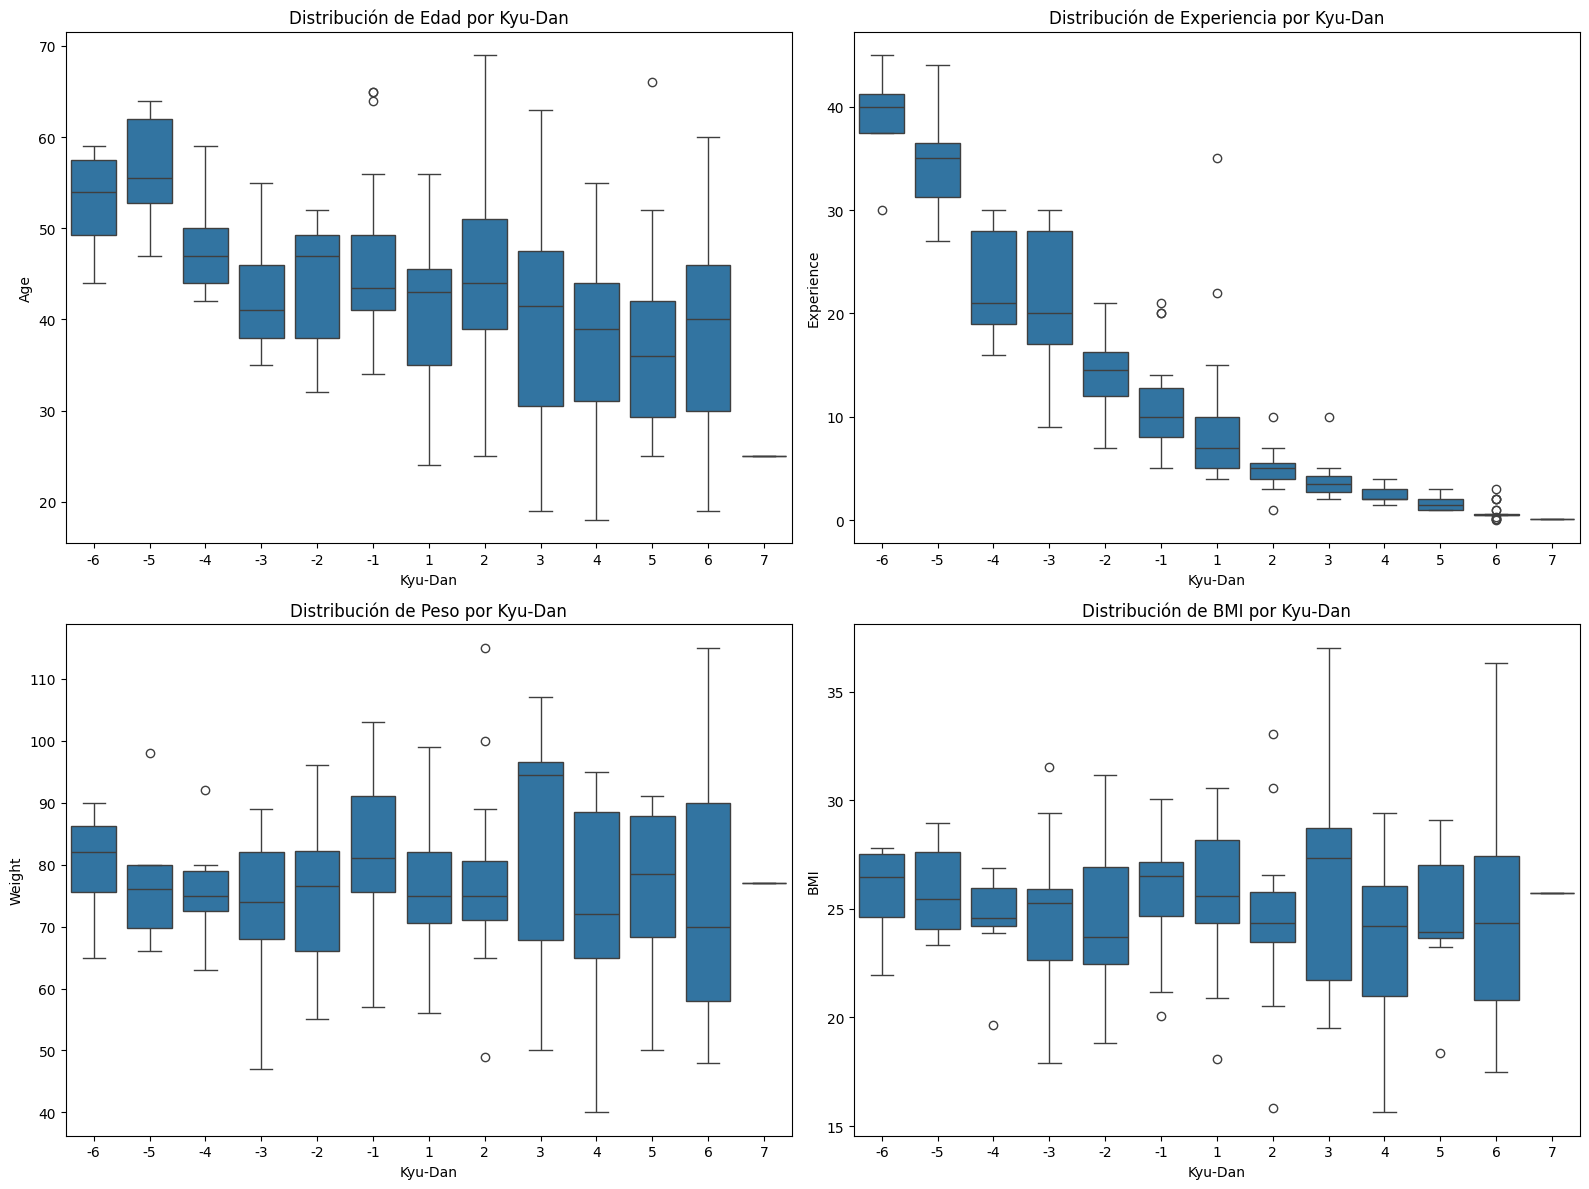

In [338]:
set_distributions_on_kd(df_bokken_base,"bokken_static_features", 'bokken')

In [293]:
df_bokken['Gender'] = df_bokken['Gender'].map({'MALE': 0, 'FEMALE': 1})
df_bokken['Type'] = df_bokken['Type'].map({'Going':0, 'Return':1})
df_bokken = df_bokken.drop(['Other', 'Sample', 'Movement'], axis=1)

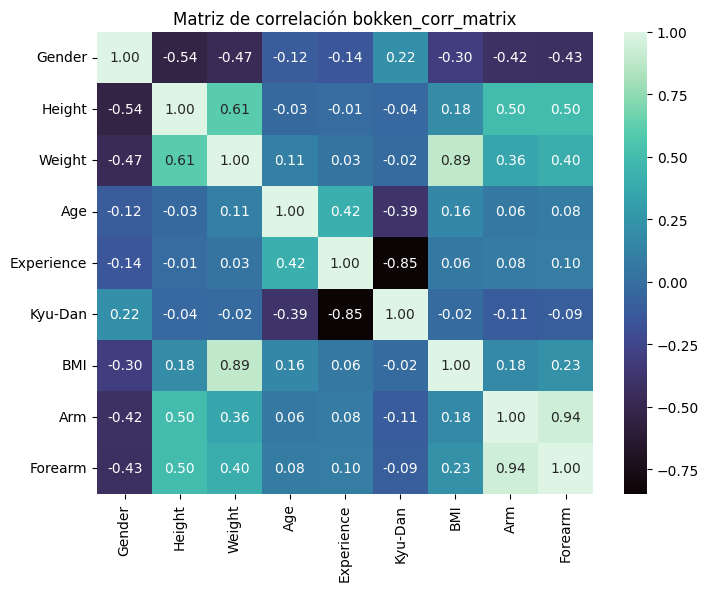

In [294]:
set_corr_matrix(df_bokken[['Name', 'Gender', 'Height', 'Weight', 'Age', 'Experience', 'Kyu-Dan',  'BMI', 'Arm', 'Forearm']], ['Name'], 'bokken_corr_matrix')

### Características propias de las Series Temporales

In [345]:
# Convertir Time a datetime 
df_bokken["Time"] = pd.to_datetime(df_bokken["Time"], unit="s")

In [346]:
duration = df_bokken.groupby('Name').agg(Duration=('Time', lambda x: (x.max() - x.min()).total_seconds()))
df_bokken['Duration']=duration[]

,Duration
Name,
AikidoBudoCinco,108.259999
AikidoBudoCuatro,90.750000
AikidoBudoDiez,90.720000
AikidoBudoNueve,89.940000
AikidoBudoOcho,89.160000
...,...
ZenraiSeis,68.746000
ZenraiSiete,72.329999
ZenraiTrece,89.416000


C:\Users\iiventura\anaconda3\envs\tfm_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


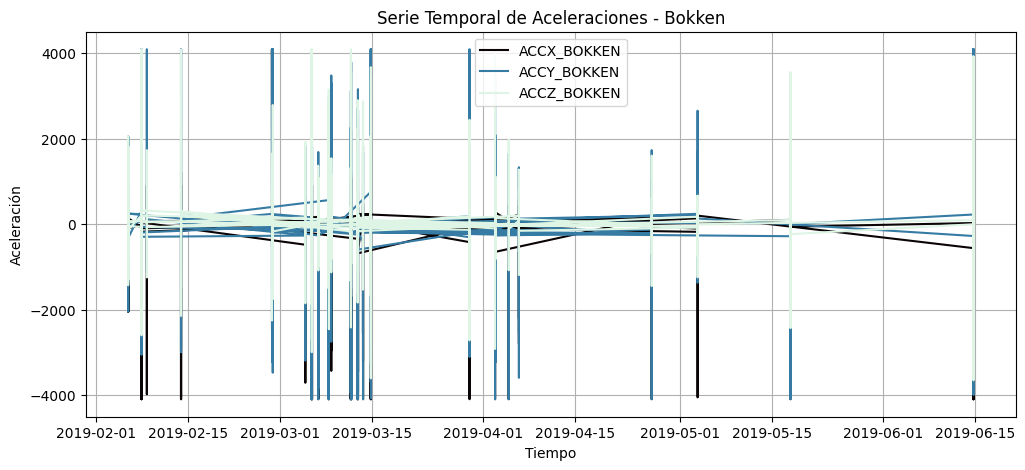

In [258]:
# Graficar aceleraciones en bokken con cmap
plt.figure(figsize=(12, 5))
plt.plot(df_bokken["Time"], df_bokken["ACCX_BOKKEN"], label="ACCX_BOKKEN", color=colors[0])
plt.plot(df_bokken["Time"], df_bokken["ACCY_BOKKEN"], label="ACCY_BOKKEN", color=colors[1])
plt.plot(df_bokken["Time"], df_bokken["ACCZ_BOKKEN"], label="ACCZ_BOKKEN", color=colors[2])
plt.xlabel("Tiempo")
plt.ylabel("Aceleración")
plt.title("Serie Temporal de Aceleraciones - Bokken")
plt.legend()
plt.grid(True)
plt.show()

In [342]:
import polars as pl
import warnings
# Ignorar warnings específicos
warnings.filterwarnings('ignore', message='Precision loss occurred in moment calculation')

## 2. Shikko Dataset

In [299]:
df_shikko = pd.read_csv('shikko_data.csv')
df_shikko.head(3)

C:\Users\iiventura\AppData\Local\Temp\ipykernel_22028\1937439231.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_shikko = pd.read_csv('shikko_data.csv')


,Unnamed: 0,Name,Gender,Height,Weight,Age,Experience,Kyu-Dan,Other,BMI,...,Q3_madgwick_cyli,Q4_madgwick_cyli,Q1_mahony_cyli,Q2_mahony_cyli,Q3_mahony_cyli,Q4_mahony_cyli,Q1_kalman_cyli,Q2_kalman_cyli,Q3_kalman_cyli,Q4_kalman_cyli
0,0,AikidoBudoCinco,MALE,175,75,44,7.0,2,NaN,24.489796,...,0.000147,-0.015789,0.999452,0.030296,0.002530,-0.013066,1.000000,0.000000,0.000000,0.000000
1,1,AikidoBudoCinco,MALE,175,75,44,7.0,2,NaN,24.489796,...,0.001852,-0.029928,0.997822,0.060729,0.006255,-0.024976,0.999825,0.000776,0.018698,0.000078
2,2,AikidoBudoCinco,MALE,175,75,44,7.0,2,NaN,24.489796,...,0.004922,-0.042244,0.995134,0.091291,0.010774,-0.035457,0.999360,0.002960,0.035651,-0.000041


In [300]:
for k in df_shikko.keys():
    print(k, df_shikko[k].dtype)

Unnamed: 0 int64
Name object
Gender object
Height int64
Weight int64
Age int64
Experience float64
Kyu-Dan int64
Other object
BMI float64
Time object
Acc_X float64
Acc_Y float64
Acc_Z float64
Gyr_X float64
Gyr_Y float64
Gyr_Z float64
Mag_X int64
Mag_Y int64
Mag_Z int64
Acc_X_sphe float64
Acc_Y_sphe float64
Acc_Z_sphe float64
Gyr_X_sphe float64
Gyr_Y_sphe float64
Gyr_Z_sphe float64
Mag_X_sphe float64
Mag_Y_sphe float64
Mag_Z_sphe float64
Acc_X_cyli float64
Acc_Y_cyli float64
Acc_Z_cyli float64
Gyr_X_cyli float64
Gyr_Y_cyli float64
Gyr_Z_cyli float64
Mag_X_cyli float64
Mag_Y_cyli float64
Mag_Z_cyli int64
Type object
Movement object
Sample int64
MOD_ACC float64
MOD_GYR float64
FORCE float64
ARM_RATIO float64
Q1_default_cart float64
Q2_default_cart float64
Q3_default_cart float64
Q4_default_cart float64
Q1_madgwick_cart float64
Q2_madgwick_cart float64
Q3_madgwick_cart float64
Q4_madgwick_cart float64
Q1_mahony_cart float64
Q2_mahony_cart float64
Q3_mahony_cart float64
Q4_mahony_cart float6

In [301]:
print(f"Número de estudiantes:{len(df_shikko['Name'].unique().tolist())}")

Número de estudiantes:185


In [302]:
for k in df_shikko.keys():
    counter= df_shikko[k].isnull().sum()
    if counter>0 :
        print(k, counter)

Other 423578


### Características propias del Participante 

In [303]:
df_shikko_base = df_shikko[['Name', 'Gender', 'Height', 'Weight', 'Age', 'Experience', 'Kyu-Dan',  'BMI', 'Other', 'ARM_RATIO']]
df_shikko_base = df_shikko_base.drop_duplicates(keep='first')

In [304]:
check_categorical_unique(df_bokken_base)

Index(['Name', 'Gender', 'Other'], dtype='object')
Columna: Gender Valores['MALE', 'FEMALE']
Columna: Other Valores['Kempo', nan, 'Judo', 'Karate', 'Taekwondo', 'Taichí', 'Judo y Karate', 'De todo', 'Chikun', 'Kembudo', 'Karate y Taekwondo', 'Karate, Taichi', 'Taichi', 'Karate y Judo', 'Kendo', 'Sambo', 'Kunfú', 'Karate, Judo, Taekwondo', 'Boxeo']


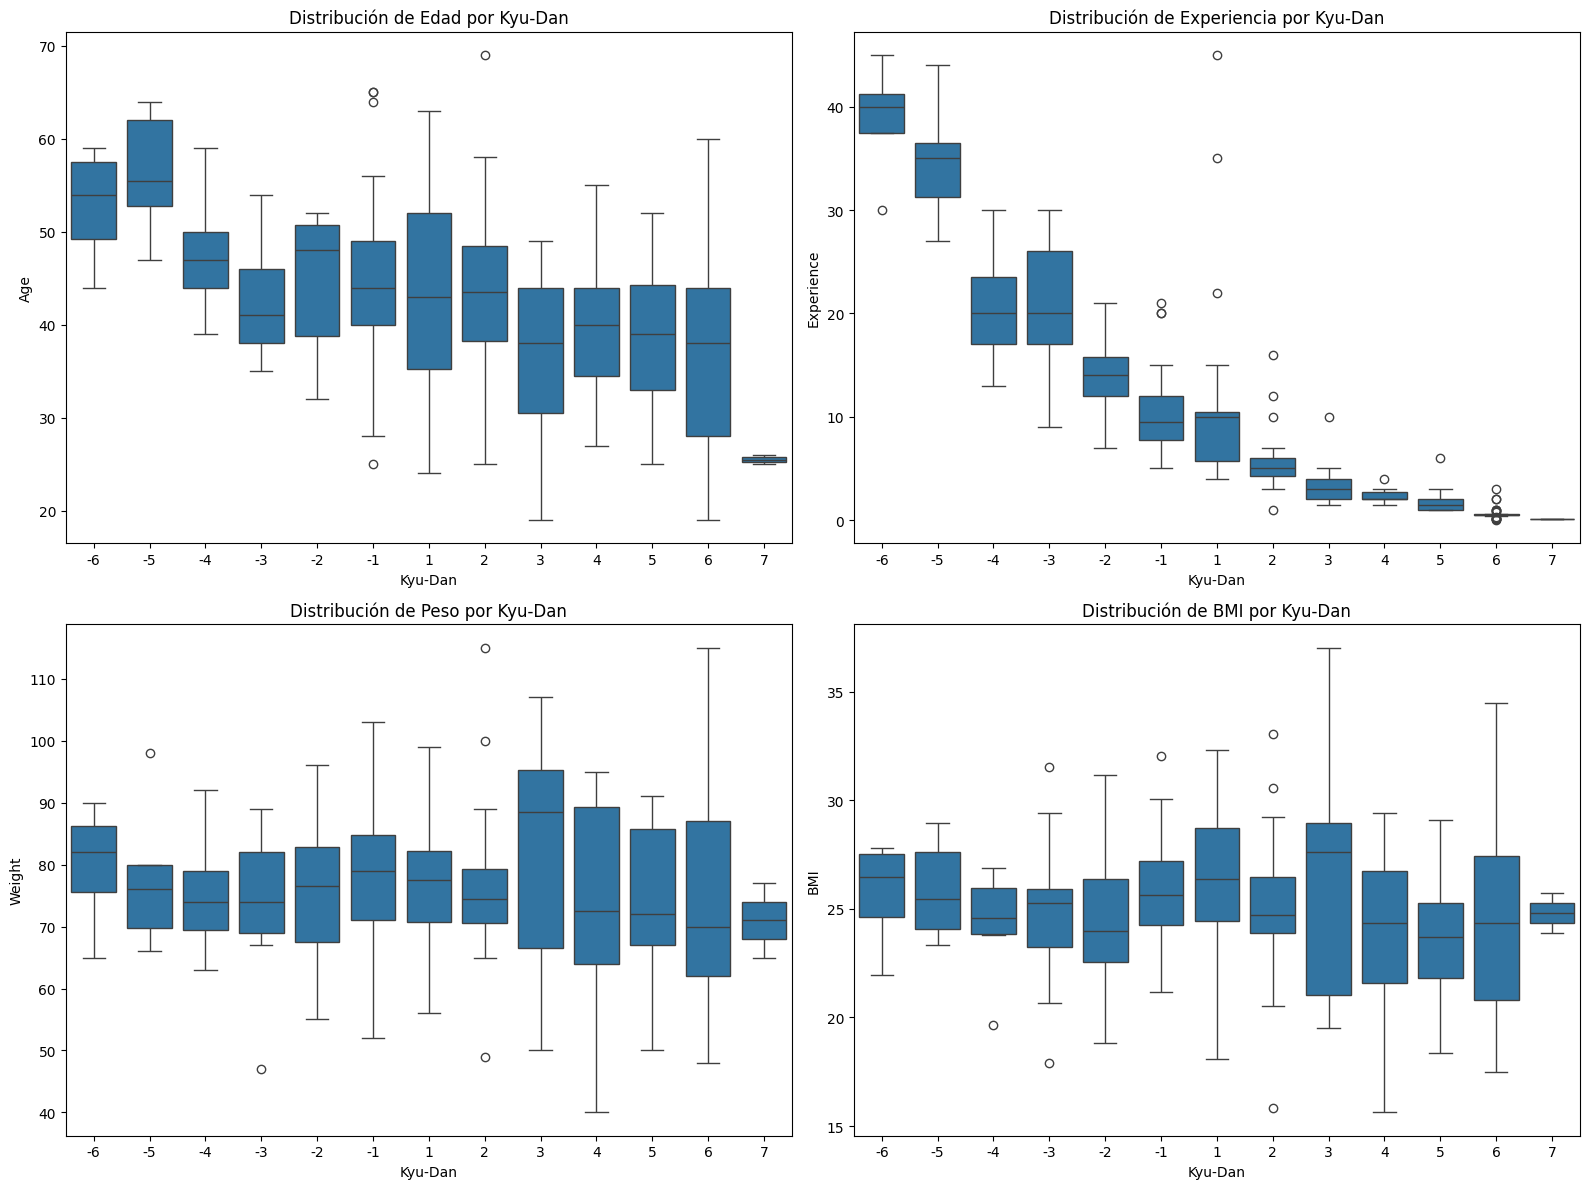

In [339]:
set_distributions_on_kd(df_shikko_base,"shikko_static_features", "shikko")

In [ ]:
df_shikko['Gender'] = df_shikko['Gender'].map({'MALE': 0, 'FEMALE': 1})
df_shikko['Type'] = df_shikko['Type'].map({'Going':0, 'Return':1})
df_shikko = df_shikko.drop(['Other', 'Sample', 'Movement'], axis=1)

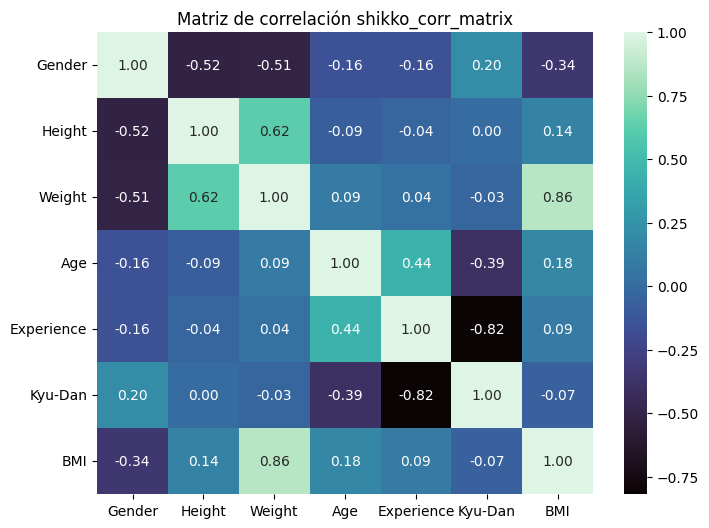

In [267]:
set_corr_matrix(df_shikko[['Name', 'Gender', 'Height', 'Weight', 'Age', 'Experience', 'Kyu-Dan',  'BMI']], ['Name'], 'shikko_corr_matrix')

### Características propias de las Series Temporales

In [268]:
# Convertir Time a datetime 
df_shikko["Time"] = pd.to_datetime(df_shikko["Time"], errors="coerce")

NameError: name 'shikko_df' is not defined

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(shikko_df["Time"], shikko_df["Acc_X"], label="Acc_X", color=colors[0])
plt.plot(shikko_df["Time"], shikko_df["Acc_Y"], label="Acc_Y", color=colors[1])
plt.plot(shikko_df["Time"], shikko_df["Acc_Z"], label="Acc_Z", color=colors[2])
plt.xlabel("Tiempo")
plt.ylabel("Aceleración")
plt.title("Serie Temporal de Aceleraciones - Shikko ")
plt.legend()
plt.grid(True)
plt.show()

# Implementación de Algoritmos No Supervisados

## 

In [242]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tslearn.clustering import KMedoids
from tslearn.metrics import dtw
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, jaccard_score
from scipy.stats import pearsonr
from itertools import product

# Funci車n para cargar y procesar datasets
def load_and_process_data(filepath):
    df = pd.read_csv(filepath)
    print(f"\nDataset: {filepath}")
    print(df.head())
    
    # Filtrar para tener un registro por participante
    df0 = df[df['Type'] == 0]
    df1 = df[df['Type'] == 1]
    
    # Merge de los datasets por 'Name' con m谷todo left
    df_merged = df0.merge(df1, on='Name', how='left', suffixes=('_0', '_1'))
    
    return df_merged

# Funci車n para evaluar clustering
def evaluate_clustering(labels, data, algorithm_name):
    silhouette = silhouette_score(data, labels)
    dbi = davies_bouldin_score(data, labels)
    chi = calinski_harabasz_score(data, labels)
    
    print(f"\n?? Evaluaci車n de {algorithm_name}")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {dbi:.4f}")
    print(f"Calinski-Harabasz Index: {chi:.4f}")
    return silhouette, dbi, chi

# Funci車n para evaluar con etiquetas reales
def evaluate_supervised(labels_pred, labels_true, algorithm_name):
    ari = adjusted_rand_score(labels_true, labels_pred)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    jaccard = jaccard_score(labels_true, labels_pred, average='macro')

    print(f"\n?? Comparaci車n con Etiquetas Reales ({algorithm_name})")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"Jaccard Index: {jaccard:.4f}")
    return ari, nmi, jaccard

# Funci車n para graficar m谷tricas
def plot_metrics(metrics, names, title):
    df_metrics = pd.DataFrame(metrics, columns=['Silhouette', 'DBI', 'CHI'], index=names)
    df_metrics.plot(kind='bar', figsize=(10, 6), title=title)
    plt.xlabel('Modelo')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()
    
 # Función para buscar mejores hiperparámetros para KMeans
def tune_kmeans(data):
    best_score = -1
    best_params = None
    
    param_grid = {
        'n_clusters': [3, 4, 5, 6, 7],
        'init': ['k-means++', 'random'],
        'max_iter': [100, 300, 500],
        'n_init': [5, 10, 20]
    }
    
    for params in product(*param_grid.values()):
        kmeans = KMeans(n_clusters=params[0], init=params[1], max_iter=params[2], n_init=params[3], random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        
        if score > best_score:
            best_score = score
            best_params = params
    
    print(f"Mejores parámetros para K-Means: {best_params}")
    return best_params

# Función para buscar mejores hiperparámetros para KMedoids
def tune_kmedoids(data):
    best_score = -1
    best_params = None
    
    param_grid = {
        'n_clusters': [3, 4, 5, 6, 7],
        'init': ['random'],
        'max_iter': [100, 300, 500]
    }
    
    for params in product(*param_grid.values()):
        kmedoids = KMedoids(n_clusters=params[0], metric="euclidean", init=params[1], max_iter=params[2], random_state=42)
        labels = kmedoids.fit_predict(data)
        score = silhouette_score(data, labels)
        
        if score > best_score:
            best_score = score
            best_params = params
    
    print(f"Mejores parámetros para K-Medoids: {best_params}")
    return best_params

# Funci車n para aplicar clustering
def apply_clustering(data, true_labels, dataset_name):
    print(f"\n?? Procesando dataset: {dataset_name}")
    metrics_list = []
    model_names = []
    
    # K-Means con valores por defecto
    kmeans_default = KMeans(n_clusters=5, random_state=42)
    kmeans_default_labels = kmeans_default.fit_predict(data)
    metrics_list.append(evaluate_clustering(kmeans_default_labels, data, "K-Means (Default)"))
    model_names.append("K-Means (Default)")
    
    # K-Means optimizado
    best_kmeans_params = tune_kmeans(data)
    kmeans_tuned = KMeans(n_clusters=best_kmeans_params[0], init=best_kmeans_params[1], max_iter=best_kmeans_params[2], n_init=best_kmeans_params[3], random_state=42)
    kmeans_tuned_labels = kmeans_tuned.fit_predict(data)
    metrics_list.append(evaluate_clustering(kmeans_tuned_labels, data, "K-Means (Tuned)"))
    model_names.append("K-Means (Tuned)")
    
    # K-Medoids con valores por defecto
    kmedoids_default = KMedoids(n_clusters=5, metric="euclidean", random_state=42)
    kmedoids_default_labels = kmedoids_default.fit_predict(data)
    metrics_list.append(evaluate_clustering(kmedoids_default_labels, data, "K-Medoids (Default)"))
    model_names.append("K-Medoids (Default)")
    
    # K-Medoids optimizado
    best_kmedoids_params = tune_kmedoids(data)
    kmedoids_tuned = KMedoids(n_clusters=best_kmedoids_params[0], metric="euclidean", init=best_kmedoids_params[1], max_iter=best_kmedoids_params[2], random_state=42)
    kmedoids_tuned_labels = kmedoids_tuned.fit_predict(data)
    metrics_list.append(evaluate_clustering(kmedoids_tuned_labels, data, "K-Medoids (Tuned)"))
    model_names.append("K-Medoids (Tuned)")
    
    plot_metrics(metrics_list, model_names, f"Comparaci車n de Modelos - {dataset_name}")
    
    if true_labels is not None:
        evaluate_supervised(kmeans_default_labels, true_labels, "K-Means (Default)")
        evaluate_supervised(kmeans_tuned_labels, true_labels, "K-Means (Tuned)")
        evaluate_supervised(kmedoids_default_labels, true_labels, "K-Medoids (Default)")
        evaluate_supervised(kmedoids_tuned_labels, true_labels, "K-Medoids (Tuned)")

# Cargar y procesar cada dataset
bokken_data = load_and_process_data("bokken_data_selected_features.csv")
shikko_data = load_and_process_data("shikko_data_selected_feature.csv")

# Aplicar clustering a cada dataset
apply_clustering(bokken_data, None, "Bokken")
apply_clustering(shikko_data, None, "Shikko")


ImportError: cannot import name 'KMedoids' from 'tslearn.clustering' (C:\Users\iiventura\anaconda3\envs\tfm_env\lib\site-packages\tslearn\clustering\__init__.py)

### 1.b  K-Medoids

## 2. Modelos aplicados al Dataset Shikko
### 2.a KMeans

### 2.b K-Medoids